# Problem set 4: Spring 2022, solutions
### Mushroom data

# Quick description

As you may know, mushrooms in the wild can be either tasty or poisonous.  This classification data set is based on some measurements from wild mushrooms and uses supervised learning to predict mushroom types.  It compares two basic early methods, logistic, and knn classification, and looks at ROC curves for each.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Core scikit learn cross validation tools also
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit

## 0. Describe dataset

This first section loads and preprocesses the dataset for you, and presents some descriptive statistics.

In [2]:
# data from Kaggle: https://www.kaggle.com/uciml/mushroom-classification
mushroom = pd.read_csv("mushrooms.csv")
mushroom.head()
print(mushroom.shape)

(8124, 23)


### 0.1 Data features

Attribute Information: (classes: edible=e, poisonous=p)

cap-shape: bell=b,conical=c,convex=x,flat=f, knobbed=k,sunken=s

cap-surface: fibrous=f,grooves=g,scaly=y,smooth=s

cap-color: brown=n,buff=b,cinnamon=c,gray=g,green=r,pink=p,purple=u,red=e,white=w,yellow=y

bruises: bruises=t,no=f

odor: almond=a,anise=l,creosote=c,fishy=y,foul=f,musty=m,none=n,pungent=p,spicy=s

gill-attachment: attached=a,descending=d,free=f,notched=n

gill-spacing: close=c,crowded=w,distant=d

gill-size: broad=b,narrow=n

gill-color: black=k,brown=n,buff=b,chocolate=h,gray=g,green=r,orange=o,pink=p,purple=u,red=e,white=w,yellow=y

stalk-shape: enlarging=e,tapering=t

stalk-root: bulbous=b,club=c,cup=u,equal=e,rhizomorphs=z,rooted=r,missing=?

stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s

stalk-surface-below-ring: fibrous=f,scaly=y,silky=k,smooth=s

stalk-color-above-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y

stalk-color-below-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y

veil-type: partial=p,universal=u

veil-color: brown=n,orange=o,white=w,yellow=y

ring-number: none=n,one=o,two=t

ring-type: cobwebby=c,evanescent=e,flaring=f,large=l,none=n,pendant=p,sheathing=s,zone=z

spore-print-color: black=k,brown=n,buff=b,chocolate=h,green=r,orange=o,purple=u,white=w,yellow=y

population: abundant=a,clustered=c,numerous=n,scattered=s,several=v,solitary=y

habitat: grasses=g,leaves=l,meadows=m,paths=p,urban=u,waste=w,woods=d

### 0.2 Data CleaningLChecking null values

In [3]:
mushroom.isnull().sum()

class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64

There's no null values in the dataset, and the dataset are in a good quality.

### 0.3 Exploratory Analysis

In [4]:
mushroom.shape

(8124, 23)

In [5]:
mushroom.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [6]:
mushroom.describe()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,...,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,...,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,...,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,...,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


## 0.4 Data Processing

### 0.4.1 separating X and y

In [7]:
# Set predictors and targets
# eliminate a bunch of features to make the problem harder,
#   and a little faster too
X = mushroom.iloc[:,1:6].copy()
y = mushroom.iloc[:,0].copy()
print(X.shape)
print(y.shape)

(8124, 5)
(8124,)


In [8]:
print(y)
print(X)
#y=class
#X= cap-shape cap-surface cap-color bruises odor

0       p
1       e
2       e
3       p
4       e
       ..
8119    e
8120    e
8121    e
8122    p
8123    e
Name: class, Length: 8124, dtype: object
     cap-shape cap-surface cap-color bruises odor
0            x           s         n       t    p
1            x           s         y       t    a
2            b           s         w       t    l
3            x           y         w       t    p
4            x           s         g       f    n
...        ...         ...       ...     ...  ...
8119         k           s         n       f    n
8120         x           s         n       f    n
8121         f           s         n       f    n
8122         k           y         n       f    y
8123         x           s         n       f    n

[8124 rows x 5 columns]


### 0.4.2 Label Encoding
* Map charcter labels to numbers for Scikit-learn

In [9]:

from sklearn.preprocessing import LabelEncoder
#LabelEncoder can be used to normalize labels. It can also be used to transform non-numerical labels
#(as long as they are hashable and comparable) to numerical labels
le = LabelEncoder() 
for col in X.columns:
    X[col] = le.fit_transform(X[col])
Encoder_y=LabelEncoder()
y = Encoder_y.fit_transform(y)
# y = 1 poisonous, 0 edible

print(X.head())




   cap-shape  cap-surface  cap-color  bruises  odor
0          5            2          4        1     6
1          5            2          9        1     0
2          0            2          8        1     3
3          5            3          8        1     6
4          5            2          3        0     5


In [10]:
# Standardized features (needed for knn)
Xmean = X.mean(axis=0)
Xstd  = X.std(axis=0)
X = (X-Xmean)/Xstd+np.random.normal(size=(X.shape[0],X.shape[1]),scale=0.25)
#X.shape[0] refers to rows numbers of X
#X.shape[1] refers to columns numbers of X
print(X.head())
print("Fraction poisonous:",y.mean())

   cap-shape  cap-surface  cap-color   bruises      odor
0   1.146071     0.118122  -0.594338  1.001749  0.714280
1   1.411195     0.114890   1.798978  1.317544 -2.032213
2  -1.756948     0.067161   1.391430  1.097258 -0.223437
3   1.286931     0.663525   1.133602  1.140439  1.254547
4   0.906288    -0.056087  -0.929766 -1.158209  0.726780
Fraction poisonous: 0.48202855736090594


## 0.5 Python hint for part 8

Problem 8 involves a small bit of Python trickiness, which it will be helpful if I just show you.  Let's say you are given a vector x which has numbers sorted highest to lowest.  You want to find the smallest entry in x such that x>threshold. 

There may be some other better ways to do this.  If you know of any feel free to tell me about them.

In [11]:
# set x to 9 to 1
# Find index to smallest entry in x > 4.0
x = np.arange(start=9, stop = 0, step = -1)
print(x)

# where is a function that will do this for you
# Unfortunately it returns a strange tupple object so you need to 
# pull out the vector with the [0] subscript
selectGT4 = np.where(x>4.)[0]
print(selectGT4)

# Now index for smallest x greater than 4.0

j = selectGT4[-1] # last entry in set > 4

print(j,x[j])

[9 8 7 6 5 4 3 2 1]
[0 1 2 3 4]
4 5


# Problem set 5

## 1. Logistic Regression and its accuracy

Set up a logistic regression, do a single train_test_split with test_size = 0.25.  Logistic regression should be run with penalty="none" and solver="lbfgs". Set random_state = 20, and the train_test_split().  Note: This means that you could compare your results to your fellow students.  (why?)

print the train score and test score, and the mean for the target (y).

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)
lr = LogisticRegression(penalty="none",solver="lbfgs", random_state = 20)
#Setting random_state a fixed value will guarantee that same sequence of random numbers are generated each time
#you run the code.
lr.fit(X_train,y_train)
print('The train score of logistic model is:',lr.score(X_train,y_train))
print('The test score of logistic model is:',lr.score(X_test, y_test))
print('The mean of y is:',np.mean(y))
print('Mean of train score is',y_train.mean())

The train score of logistic model is: 0.7679304119481372
The test score of logistic model is: 0.758739537173806
The mean of y is: 0.48202855736090594
Mean of train score is 0.4817003118332513


## 2. Our more standard randomized cross-validation (25 runs, testsize = 0.25)

Do a standard monte-carlo run with a randomized cross validation using cross_validate(), and the logistic regression from the last part.

In [13]:
from sklearn.model_selection import ShuffleSplit
nmc=25 
lr = LogisticRegression(penalty="none",solver="lbfgs", random_state = 20)
lr.fit(X_train,y_train)
shuffle = ShuffleSplit(n_splits=nmc, test_size=.25)
CVInfo = cross_validate(lr, X, y, cv=shuffle,return_train_score=True)

     
    # record train accuracy
print(np.mean(CVInfo['train_score']))
    # record test accuracy
print(np.mean(CVInfo['test_score']))


0.7666962087641555
0.7619300837026097


## 3. Confusion matrix

For the train_test_split from problem 1, reestimate logistic on the training data, and find the confusion matrix, accuracy, precision, and recall, on the test data.

In [32]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)
lr = LogisticRegression(penalty="none",solver="lbfgs", random_state = 20)
lr.fit(X_train,y_train)
yhat = lr.predict(X_test)
cmat=confusion_matrix(y_test,yhat)
tn, fp, fn, tp = cmat.ravel()
precision = tp/(tp+fp)
recall = tp/(tp+fn)
Accuracy=tn+tp/(tn+fp+fn+tp)
print('confusion matrix',cmat)
print('Accuracy',Accuracy)
print('precision',precision)
print('recall',recall)

confusion matrix [[827 234]
 [233 737]]
Accuracy 827.3628754308222
precision 0.7590113285272915
recall 0.7597938144329897


## 4. Threshold sweep

Using a logistic model fit on the training data, find the probabilities for y = 1 from the test data, and then do a sweep of thresholds from 0 0.95 using
np.arange(0.0,1.00,0.05)

For each threshold level find the predicted y value, and using this find the confusion matrix, and from this get precision, recall, and false positives.  Store those in lists along with the threshold values.

Plot the three values, precision, recall, and false positives as a function of threshold.

Note:  All I want here is a the plot.  No need to print any of those intermediate results.

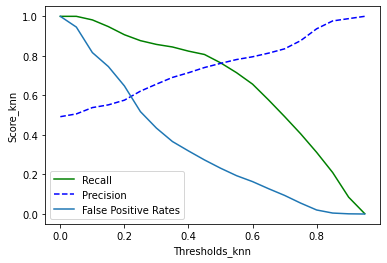

In [31]:
from sklearn.metrics import roc_curve
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)
lr = LogisticRegression(penalty="none",solver="lbfgs", random_state = 20)
lr.fit(X_train,y_train)

y_prob = lr.predict_proba(X_test)[:,1]
false_pos_rates=[]
plist = []
rlist = []
thresholds=[]
for threshold in np.arange(start=0.0,stop=1.00,step=0.05):
    yhat = y_prob > threshold
    cmat = confusion_matrix(y_test, yhat)
    tn, fp, fn, tp = cmat.ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    rate=fp/(tn+fp)
    plist.append(precision)
    rlist.append(recall)
    thresholds.append(threshold)
    false_pos_rates.append(rate)

plt.plot(thresholds,rlist,"g-", label="Recall")
plt.plot(thresholds,plist,"b--", label="Precision")
plt.plot(thresholds,false_pos_rates)

plt.ylabel("Score_knn")
plt.xlabel("Thresholds_knn")
plt.legend(['Recall','Precision','False Positive Rates'])

## 4 KNN Classifier and its accuracy

Set up a knn classifier.  Try to find the optimal neighbors by sweeping from 1 to 40.   Store training and test accuracy for each neighbor (as we've done many times).  Finally plot the accuracy for both test and training as a function of the number of neighbors.  Store the optimal neighbors in a variables best_neighbors.

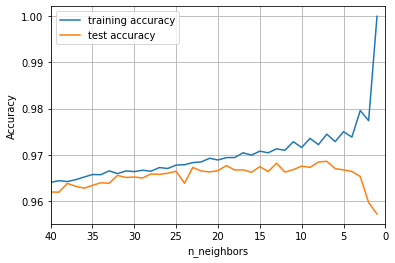

In [27]:
from sklearn.neighbors import KNeighborsClassifier
training_accuracy = []
test_accuracy = []
neighbors_settings = range(1, 41)
shuffle = ShuffleSplit(n_splits=nmc, test_size=.25)

for i in neighbors_settings:
    knn = KNeighborsClassifier(n_neighbors=i)
    

    CVInfo = cross_validate(knn, X, y, cv=shuffle,return_train_score=True)
     # record train accuracy
    training_accuracy.append(np.mean(CVInfo['train_score']))
    # record test accuracy
    test_accuracy.append(np.mean(CVInfo['test_score']))
            
fig, ax = plt.subplots()
ax.plot(neighbors_settings, training_accuracy, label="training accuracy")
ax.plot(neighbors_settings, test_accuracy, label="test accuracy")
ax.set_xlim(40, 0)
ax.set_ylabel("Accuracy")
ax.set_xlabel("n_neighbors")
ax.grid()
ax.legend()

In [28]:
nbest = np.argmax(test_accuracy)
best_neighbors = neighbors_settings[nbest]
print("best_neighbors=",best_neighbors)
print(test_accuracy)


best_neighbors= 7
[0.9571639586410634, 0.959645494830133, 0.9652781880846873, 0.9664007877892664, 0.9667159034958149, 0.967011324470704, 0.9685869030034466, 0.9684293451501723, 0.9672673559822746, 0.9675430822255047, 0.9667749876907927, 0.9662432299359921, 0.9681733136386016, 0.9663613983259477, 0.967424913835549, 0.9662038404726735, 0.9667355982274741, 0.9666962087641556, 0.9676612506154604, 0.9665583456425406, 0.9662826193993106, 0.9664795667159035, 0.9672673559822746, 0.9638207779419006, 0.9664401772525849, 0.9660068931560807, 0.9657508616445101, 0.9658493353028064, 0.9649630723781388, 0.9651797144263909, 0.9650812407680945, 0.9655342195962581, 0.9638207779419006, 0.9639389463318563, 0.9633677991137372, 0.9627572624322994, 0.9631708517971442, 0.9638010832102413, 0.961890694239291, 0.9619497784342687]


## 5 KNN classifier accuracy 

As a quick check run your "best_neighbors" classifer on the original train set from part 1, and report the score on the original train and test sets from part 1.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)
knn = KNeighborsClassifier(n_neighbors=best_neighbors)
knn.fit(X_train,y_train)
print(knn.score(X_train,y_train))
print(knn.score(X_test, y_test))

0.9716067618578696
0.9704579025110783


## 6 Threshold sweep

Repeat the theshold sweep from part 4, plotting precision, recall, and false positives for the knn classifier.  Trained on the training sample, and all values estimated on the test sample.  Plot the same plot from part 4 for knn.  How do the two plots compare?  Which method looks better?

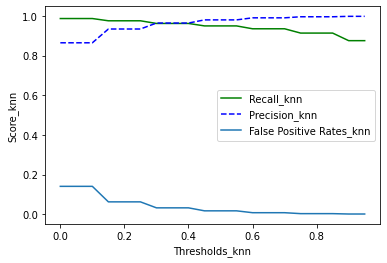

In [30]:

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)
knn = KNeighborsClassifier(n_neighbors=best_neighbors)
knn.fit(X_train,y_train)

y_prob_knn = knn.predict_proba(X_test)[:,1]
false_pos_rates_knn=[]
plist_knn = []
rlist_knn = []
thresholds=[]
for threshold in np.arange(start=0.0,stop=1.00,step=0.05):
    yhat_knn = y_prob_knn > threshold
    cmat_knn = confusion_matrix(y_test, yhat_knn)
    tn_knn, fp_knn, fn_knn, tp_knn = cmat_knn.ravel()
    precision_knn = tp_knn/(tp_knn+fp_knn)
    recall_knn = tp_knn/(tp_knn+fn_knn)
    rate_knn=fp_knn/(tn_knn+fp_knn)
    plist_knn.append(precision_knn)
    rlist_knn.append(recall_knn)
    thresholds.append(threshold)
    false_pos_rates_knn.append(rate_knn)
plt.plot(thresholds,rlist_knn,"g-", label="Recall")
plt.plot(thresholds,plist_knn,"b--", label="Precision")
plt.plot(thresholds,false_pos_rates_knn)

plt.ylabel("Score_knn")
plt.xlabel("Thresholds_knn")
plt.legend(['Recall_knn','Precision_knn','False Positive Rates_knn'])

The knn model looks better as it has lower false positive rate, higher recall score, and higher precision score compared with the resulted plot of logistic model.

## 7 ROC curves and AUC

Plot the ROC curves (on the same plot) for the logistic classifier, and the knn classifier.  Get the probabilities using predict_proba on the test sample from part 1.  Use the roc_curve() to get the curve, and plot the two together.
Also, find the AUC (area under the curve) for both models.

Is there a definite winner in the race between these models?  Why or why not?

Text(0, 0.5, 'True positive rate (recall)')

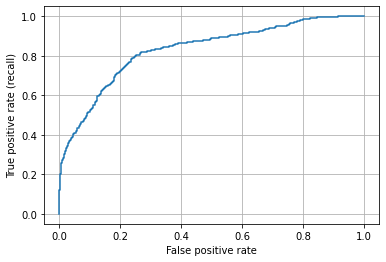

In [20]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)
lr = LogisticRegression(penalty="none",solver="lbfgs", random_state = 20)
lr.fit(X_train,y_train)
y_prob_lr = lr.predict_proba(X_test)[:,1]
fpr_lr, tpr_lr, thresholds = roc_curve(y_test, y_prob_lr)
plt.plot(fpr_lr,tpr_lr)
plt.grid()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate (recall)")


In [21]:
from sklearn.metrics import roc_auc_score
print("AUC:",roc_auc_score(y_test, y_prob_lr))

AUC: 0.8307273593250323


Text(0, 0.5, 'True positive rate (recall)')

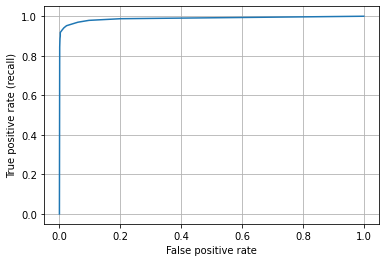

In [22]:
#knn
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)
knn = KNeighborsClassifier(n_neighbors=best_neighbors)
knn.fit(X_train,y_train)
y_prob_knn = knn.predict_proba(X_test)[:,1]
fpr_knn, tpr_knn, thresholds = roc_curve(y_test, y_prob_knn)
# fpr, tpr, thresholds = roc_curve(y,df)
plt.plot(fpr_knn,tpr_knn)
plt.grid()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate (recall)")

In [23]:
print("AUC:",roc_auc_score(y_test, y_prob_knn))

AUC: 0.9888351308508465


Text(0, 0.5, 'True positive rate (recall)')

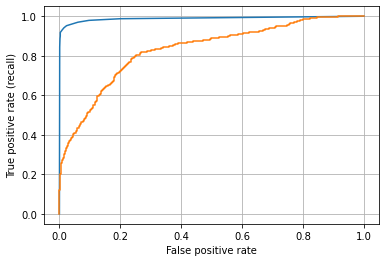

In [24]:
#plot the ROC curve of knn and logistic model together
fig, ax = plt.subplots()
ax.plot(fpr_knn,tpr_knn)
ax.plot(fpr_lr,tpr_lr)
plt.grid()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate (recall)")


The knn model definitely has better ROC curve compared with that of logistic model.
The ROC curve has the shape that is close to the perfect test as it hangs along the y-axis vertically and closely hangs along the top of the x-axis horizontally.Also, the AUC score for knn model is almost to 100 which is larger than the AUC score of logistic model.

## 8 Recall > 0.95 

For this problem I want you to find the best recall/false positive combination for each model, for a recall level greater than 0.95.  In other words you have been asked to deliver on a model that generates a 0.95 recall or better, and you want the model that does this with the smallest possible false positive rate.  What are these two rates for the logistic and knn models?  (I don't need to know any details about thresholds for this problem.  You can just use your recall, false positive lists from your plots.)

In [25]:
recall_knn=np.array(rlist_knn)
print(recall_knn)
selectGT4 = np.where(recall_knn>0.95)[0]
print(selectGT4)
false_positive_rates_knn=np.array(false_pos_rates_knn)
j = selectGT4[-1]
print('recall level greater than 0.95 for knn model is',recall_knn[j])
print('smallest false positive rate for knn model is', false_pos_rates_knn[j])
# Now index for smallest x greater than 4.0

# last entry in set > 4

[0.98901099 0.98901099 0.97902098 0.97902098 0.96903097 0.96903097
 0.96103896 0.96103896 0.95304695 0.95304695 0.94105894 0.93606394
 0.93606394 0.92707293 0.92707293 0.91308691 0.91308691 0.88811189
 0.88811189 0.85414585]
[0 1 2 3 4 5 6 7 8 9]
recall level greater than 0.95 for knn model is 0.9530469530469531
smallest false positive rate for knn model is 0.020388349514563107


In [26]:
recall=np.array(rlist)
selectGT4 = np.where(recall>0.95)[0]
false_positive_rates=np.array(false_pos_rates)
lr = selectGT4[-1]
print('recall level greater than 0.95 for logistic model is',recall[lr])
print('smallest false positive rate for logistic model is', false_pos_rates[lr])

recall level greater than 0.95 for logistic model is 0.954864593781344
smallest false positive rate for logistic model is 0.7504835589941973
